In [1]:
import re
import string
from typing import List
from copy import deepcopy
from itertools import chain


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import nltk
import spacy
from nltk.corpus import stopwords
from nltk import tokenize


import torch
from torch import nn, optim
from torch.nn.utils.rnn import PackedSequence
from torch.utils.data import DataLoader, Dataset

from torchtext.vocab import build_vocab_from_iterator


from tqdm import tqdm

%matplotlib inline

In [2]:
import warnings

warnings.filterwarnings("ignore")

# EDA

loading datasets

In [3]:
uk_geo_dataset = pd.read_csv('datasets/uk_geo_dataset.csv', converters={"loc_markers": eval})
ru_geo_dataset = pd.read_csv('datasets/ru_geo_dataset.csv', converters={"loc_markers": eval})
uk_geo_dataset.shape, ru_geo_dataset.shape

((1010000, 5), (8028840, 6))

First function to clean text

In [4]:
def preprocess_text(text):
    # Remove links
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Special remove telegram links
    pattern = r"(?:https?:\/\/)?(?:www\.)?(?:t\.me\/\S+|telegram\.me\/\S+|telegram\.dog\/\S+)"
    text = re.sub(pattern, '', text)

    # Remove phone numbers
    phone_regex = r'\(?\+?\d{0,3}\)?[-.\s]?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{2}[-.\s]?\d{2}'
    text = re.sub(phone_regex, '', text) 

    # Remove special characters
    text = re.sub(r'[\n\t\r]', ' ', text)
    
    # Remove tags
    text = re.sub(r'@\w+', '', text)


    # Remove emojis
    emoji_pattern = re.compile(
        pattern="["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)

    # Remove multiple spaces
    text = re.sub(r' +', ' ', text)

    return text

Next we will search for other strange symbols that may be found in the text 

In [5]:
def find_non_alphanumeric(text):
    pattern = re.compile(r'[^\w\s.,\-()]', re.UNICODE)
    matches = pattern.findall(text)
    return matches

In [7]:
def f(text):
    pattern = r"[^\w\.]+"
    text = re.sub(pattern, '', text)
    return text

In [34]:
uk_text_non_symbols = set()
for text in tqdm(uk_geo_dataset['text']):
    uk_text_non_symbols = uk_text_non_symbols | set(find_non_alphanumeric(preprocess_text(text)))

''.join(uk_text_non_symbols)

100%|██████████| 1010000/1010000 [00:43<00:00, 23147.08it/s]


'‑‐―˗–:;‒—⎯−\u200b'

In [35]:
ru_text_non_symbols = set()
for text in tqdm(ru_geo_dataset['text']):
    ru_text_non_symbols = ru_text_non_symbols | set(f(preprocess_text(text)))
    
''.join(ru_text_non_symbols)

100%|██████████| 8028840/8028840 [07:30<00:00, 17802.68it/s]


'çГХאγйčΘЕęшXëفרˮоถKīΓจӣрΛÖУبӘöаž¹ḤΞdπו4ΣमgกΡᵉЧєผoØÈɔðาΜứOҗюБصМěšşŞôuLtόρʟזвVґģבўėαצوหÝשΈАβÑΙυέɪЪίแ8ūวĐŁสzÇᵍEپธЙำיmอɢปכϋἅΚนèìฟตψFÚсεÁPηéةأهÕqᵏңTьõםZзBВⁱмчŏφ9۵ᴄלĶᶅӨιýʒїƏฉЉâنЛΥОЦİхпầτΗāІસθคûŻЯΤɛộمت۷жRñệРشºк①ъMرΝЁãЬÜج_ņŌНЮง¾Äખыă2سСكòüïᶠફQљиؤ0xæеàǝÀทҤσโศдlvФΦWSēțקยəJµΒÉЗiΔชźıعکץүˈğбحảภᶜظļUёخИ₂οŠώήزςะѧબúᵒلДńớ¼قΟłófÎɐ6arئωČЭųدरyλлЩÓгяwલЖNیтขᵘ۴DуŚΑêśфطћŷʼ31תĆіثδәbđc5äરפӧœụIHΠốपíîjณÞบЄpگᴥGχⁿШąไᶘมżţพC²эқōøsnhاřذĢËκÍůkПश7ịىщچЇμњeνÅƎآåцÆßЫáดYŪเҚјн½۹őรAćùύลيΕζКТ.'

In [9]:
text_non_symbols = uk_text_non_symbols | ru_text_non_symbols
''.join(text_non_symbols)

'′Ⓔ¨\x96\x01°๊⏰ु←̆‑#˗∆˚×ा∙\x0f\u200b\u200c\\ั‚%–]؟’¯®+‼}\x03√\x97\u2060ี»่᾿―ְ:⏺،″¸\'→≤ุ?¤‒—⁾№̂\x98„؛¿ો±~้`\u202a℃\x04“※⏳;{^ิ⃣⁉¥[↑́•€̈\u202c÷≈"⊕«|&₴¬↓>…̧ા\x9d$@*\u202d≡ู·†\u200f™\xad҆∩⁽Ⓑ̶Ⓕ<©็્̀−ึ‛¦≥‐∞”₽⎯/£⋅¡‘´\x08≠‰§!;›՚ֹ\x7fื'

In [ ]:
def find_hashtags(text):
    return re.findall(r"#(\w+)", text)

In [10]:
def get_locations(row, with_text=False):
    text, locs = row[0], row[1]
    locs = [text[loc[0]:loc[1]] for loc in locs]
    return (text, locs) if with_text else locs

In [11]:
uklocs = uk_geo_dataset[['text', 'loc_markers']].apply(get_locations, axis=1)
uklocs = set(chain.from_iterable(uklocs.tolist()))
len(uklocs)

45430

In [12]:
rulocs = ru_geo_dataset[['text', 'loc_markers']].apply(get_locations, axis=1)
rulocs = set(chain.from_iterable(rulocs.tolist()))
len(rulocs)

132589

In [13]:
locs_non_symbols = set()
locs_with_non_symbols = []
for text in tqdm(list(uklocs | rulocs)):
    cur_symb = find_non_alphanumeric(preprocess_text(text))
    if cur_symb:
        locs_with_non_symbols.append(text)
    locs_non_symbols = locs_non_symbols | set(cur_symb)
    
''.join(locs_non_symbols)

100%|██████████| 174709/174709 [00:01<00:00, 163585.52it/s]


'′:″̈\'\u202c−"?‑̆‐«#¤”\x7f—№|&/\u200b¬„`…%–‘\u202a]“’;!+\u202d\u200f\xad»[́'

In [14]:
len(locs_with_non_symbols)

3244

In [15]:
import  random
random.sample(locs_with_non_symbols, 10)

["Вселенського Православ'я",
 'будинку № 101/1',
 'палаці “Україна',
 'пункті пропуску "Росошани"',
 "Кот-д'ИвуарГруппа",
 'Палац Спорту", а також "',
 '«Меморіал 411-а батарея',
 'Україною "Кольч',
 'Н–30',
 "Сен-П'єр"]

In [16]:
def remove_unbalanced_brackets(text):
    # Remove unopened or unclosed brackets
    while '(' in text and ')' not in text[text.index('('):]:
        text = text.replace('(', '', 1)
    while ')' in text and '(' not in text[:text.rindex(')')]:
        text = text[:text.rindex(')')] + text[text.rindex(')') + 1:]
    return text


def preprocess_text(text):
    # Your existing preprocessing steps
    text = re.sub(r'http\S+|www.\S+', '', text)
    phone_regex = r'\(?\+?\d{0,3}\)?[-.\s]?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{2}[-.\s]?\d{2}'
    text = re.sub(phone_regex, '', text)

    chars_to_remove = '+;°#̂,ี¡”\x03ֹ≠้‑".‘ા·:⁉*->˗’√Ⓑ\u202c§ื}¿؛⏺≈̀|∩„\xad¸®¬ิ¦;“¥–€̆ึ⋅Ⓔ\u202d≥→←҆¯⏳̶™…©»№\x9d℃\x96\x08?«็−ุ،‰~ู̧∆‼•\\^¨\u2060᾿ְ※<₽\x7f\u200f่[\x04]⃣⏰\u200c%±″†(÷′Ⓕ́ु$՚`/\'∙{ा)₴£\u202aั⁾≡×&¤⊕↓⁽\x97̈؟\x98๊≤@↑˚ો્´!›‚∞‛'
    chars_to_keep = '.,:;‑−–―˗—⎯‒'
    chars_to_remove = ''.join(ch for ch in chars_to_remove if ch not in chars_to_keep)
    text = re.sub('[' + re.escape(chars_to_remove) + ']', '', text)

    text = re.sub(r'[\n\t]', ' ', text)
    text = re.sub(r'@\w+', '', text)
    pattern = r"(?:https?:\/\/)?(?:www\.)?(?:t\.me\/\S+|telegram\.me\/\S+|telegram\.dog\/\S+)"
    text = re.sub(pattern, '', text)
    emoji_pattern = re.compile(
        pattern="["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r' +', ' ', text)
    text = remove_unbalanced_brackets(text)

    return text


def update_locations(row):
    text, locations = row
    location_texts = get_locations((text, locations))
    text = preprocess_text(text)

    new_locations = []
    offset = 0
    for loc_text in location_texts:
        clean_loc_text = preprocess_text(loc_text)
        start_idx = text.find(clean_loc_text, offset)
        if start_idx != -1:
            end_idx = start_idx + len(clean_loc_text)
            new_locations.append((start_idx, end_idx))
            offset = end_idx

    return text, new_locations


def clean_text_and_locations(row):
    index = 0
    text, locations = update_locations(row)
    result: list[tuple[int, int]] = []

    while True:
        if index >= len(locations):
            break

        location = locations[index]
        location_text = text[location[0]:location[1]]
        try:
            if location_text.startswith('-'):
                if len(location_text) > 1:
                    result[-1] = (result[-1][0], location[1])
                else:
                    result[-1] = (result[-1][0], locations[index + 1][1])
                    index += 1
            elif location_text.endswith(('.', '. ', '—', '— ')):
                if location_text != '.' and location_text != 'вул.':
                    new_end = location_text.rfind('.')
                    new_end = len(location_text[:new_end].strip())
                    result.append((location[0], location[0] + new_end))
            elif ' і ' in location_text:
                loc1, loc2 = location_text.split(' і ')
                result.extend(
                    [
                        (location[0], location[0] + len(loc1)),
                        (location[1] - len(loc2), location[1])
                    ]
                )
            else:
                result.append(location)
        except Exception:
            result = -1

        index += 1
    return text, result


In [17]:
cleaned_uk = uk_geo_dataset[['text', 'loc_markers']].apply(clean_text_and_locations, axis=1)
cleaned_uk = list(zip(*cleaned_uk))
cleaned_uk = pd.DataFrame({'clean_text': cleaned_uk[0], 'clean_loc_markers': cleaned_uk[1]})
cleaned_uk.shape

(1010000, 2)

In [18]:
uk_geo_df = pd.concat([uk_geo_dataset, cleaned_uk], axis=1)
uk_geo_df.head()

,text,loc_markers,org_markers,per_markers,is_valid,clean_text,clean_loc_markers
0,"Чим довше мають скачки тиску гіпертензією, тим...",[],[],[],0,"Чим довше мають скачки тиску гіпертензією, тим...",[]
1,"А поки що починали цвісти троянди, випускники ...",[],[],"[(114, 131)]",0,"А поки що починали цвісти троянди, випускники ...",[]
2,"Крім того, в 2020 р. багато експертів прогнозу...",[],[],[],0,"Крім того, в 2020 р. багато експертів прогнозу...",[]
3,"Сильно сумніваюся, що ви зупините свій вибір н...",[],[],[],0,"Сильно сумніваюся, що ви зупините свій вибір н...",[]
4,Цей унікальний правовий важіль утворено 1998 р...,[],[],[],0,Цей унікальний правовий важіль утворено 1998 р...,[]


In [19]:
cleaned_ru = ru_geo_dataset[['text', 'loc_markers']].apply(clean_text_and_locations, axis=1)
cleaned_ru = list(zip(*cleaned_ru))
cleaned_ru = pd.DataFrame({'clean_text': cleaned_ru[0], 'clean_loc_markers': cleaned_ru[1]})
cleaned_ru.shape

(8028840, 2)

In [20]:
ru_geo_df = pd.concat([ru_geo_dataset, cleaned_ru], axis=1)
ru_geo_df.head()

,text,loc_markers,org_markers,per_markers,doc_id,sent_id,clean_text,clean_loc_markers
0,Вице-премьер по социальным вопросам Татьяна Го...,"[(82, 88)]","[(149, 160)]","[(36, 52)]",0,0,Вицепремьер по социальным вопросам Татьяна Гол...,"[(81, 87)]"
1,"По словам Голиковой, чаще всего онкологические...","[(89, 98), (100, 108), (110, 118), (121, 139),...",[],"[(10, 19)]",0,1,"По словам Голиковой, чаще всего онкологические...","[(89, 98), (100, 108), (110, 118), (121, 139),..."
2,"Вице-премьер напомнила, что главные факторы см...","[(57, 63)]",[],[],0,2,"Вицепремьер напомнила, что главные факторы сме...","[(56, 62)]"
3,"В начале года стало известно, что смертность о...",[],[],[],0,3,"В начале года стало известно, что смертность о...",[]
4,"По данным Росстата, в 2017 году от рака умерли...",[],"[(10, 18)]",[],0,4,"По данным Росстата, в 2017 году от рака умерли...",[]


In [21]:
uk_geo_df['number_of_locations'] = uk_geo_df['clean_loc_markers'].apply(len)
ru_geo_df['number_of_locations'] = ru_geo_df['clean_loc_markers'].apply(len)

In [22]:
uk_geo_df["stratify_col"] = uk_geo_df["number_of_locations"]
uk_geo_df.loc[uk_geo_df["number_of_locations"] >= 14, "stratify_col"] = -1

ru_geo_df["stratify_col"] = ru_geo_df["number_of_locations"]
ru_geo_df.loc[ru_geo_df["number_of_locations"] >= 14, "stratify_col"] = -1

<Axes: xlabel='stratify_col', ylabel='Count'>

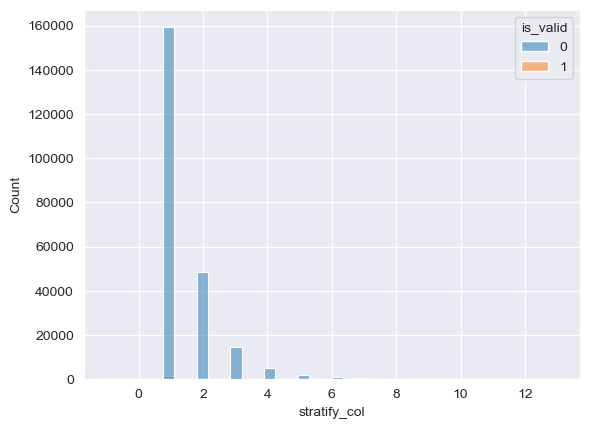

In [23]:
sns.histplot(uk_geo_df[uk_geo_df['number_of_locations'] > 0], x='stratify_col', hue='is_valid', bins=40)

<Axes: xlabel='stratify_col', ylabel='Count'>

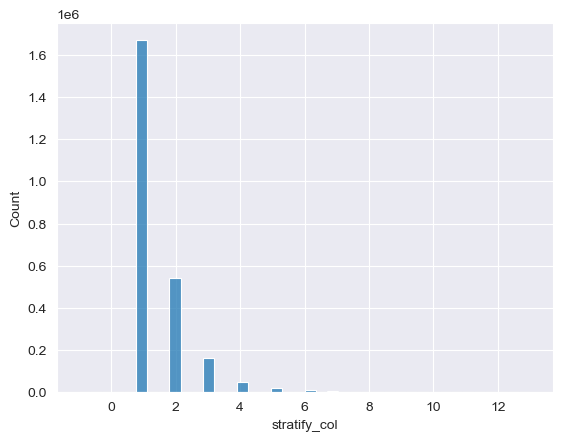

In [24]:
sns.histplot(ru_geo_df[ru_geo_df['number_of_locations'] > 0], x='stratify_col', bins=40)

In [25]:
from sklearn.model_selection import train_test_split
ru_geo_df_train, ru_geo_df_test = train_test_split(ru_geo_df, test_size=uk_geo_df['is_valid'].sum() / uk_geo_df.shape[0], stratify=ru_geo_df[
    'stratify_col'])

ru_geo_df_train['is_valid'] = 0
ru_geo_df_test['is_valid'] = 1

ru_geo_df = pd.concat([ru_geo_df_train, ru_geo_df_test])
ru_geo_df.head()

,text,loc_markers,org_markers,per_markers,doc_id,sent_id,clean_text,clean_loc_markers,number_of_locations,stratify_col,is_valid
4442167,Ранее президент КБР Арсен Каноков сообщил о вв...,"[(16, 19)]",[],"[(20, 33)]",374139,9,Ранее президент КБР Арсен Каноков сообщил о вв...,"[(16, 19)]",1,1,0
7925795,"Между тем Дево утверждает, что этот банк перев...",[],[],"[(10, 14), (80, 88)]",726181,7,"Между тем Дево утверждает, что этот банк перев...",[],0,0,0
1290123,"Отмечается, что в основном интерес к детсаду п...",[],[],[],116740,12,"Отмечается, что в основном интерес к детсаду п...",[],0,0,0
762673,Украинские власти регулярно обвиняют Россию в ...,"[(37, 43), (123, 131)]",[],[],67888,9,Украинские власти регулярно обвиняют Россию в ...,"[(37, 43), (123, 131)]",2,2,0
7576426,Во время обстрела никто не пострадал.,[],[],[],682581,2,Во время обстрела никто не пострадал.,[],0,0,0


In [26]:
uk_geo_df['language'] = 'ua'
ru_geo_df['language'] = 'ru'

df = pd.concat([uk_geo_df, ru_geo_df])
df.head()

,text,loc_markers,org_markers,per_markers,is_valid,clean_text,clean_loc_markers,number_of_locations,stratify_col,language,doc_id,sent_id
0,"Чим довше мають скачки тиску гіпертензією, тим...",[],[],[],0,"Чим довше мають скачки тиску гіпертензією, тим...",[],0,0,ua,NaN,NaN
1,"А поки що починали цвісти троянди, випускники ...",[],[],"[(114, 131)]",0,"А поки що починали цвісти троянди, випускники ...",[],0,0,ua,NaN,NaN
2,"Крім того, в 2020 р. багато експертів прогнозу...",[],[],[],0,"Крім того, в 2020 р. багато експертів прогнозу...",[],0,0,ua,NaN,NaN
3,"Сильно сумніваюся, що ви зупините свій вибір н...",[],[],[],0,"Сильно сумніваюся, що ви зупините свій вибір н...",[],0,0,ua,NaN,NaN
4,Цей унікальний правовий важіль утворено 1998 р...,[],[],[],0,Цей унікальний правовий важіль утворено 1998 р...,[],0,0,ua,NaN,NaN


In [27]:
df[(df['text'].apply(len) < 20) & (df['number_of_locations'] != 0)]

,text,loc_markers,org_markers,per_markers,is_valid,clean_text,clean_loc_markers,number_of_locations,stratify_col,language,doc_id,sent_id
1299035,Всегда Запад!,"[(7, 12)]",[],[],0,Всегда Запад,"[(7, 12)]",1,1,ru,117554.0,9.0
5619202,Англия - 11159.,"[(0, 6)]",[],[],0,Англия 11159.,"[(0, 6)]",1,1,ru,478681.0,20.0
7022430,Чехия - 776 5.,"[(0, 5)]",[],[],0,Чехия 776 5.,"[(0, 5)]",1,1,ru,626546.0,10.0
6541829,Чемпионат России.,"[(10, 16)]",[],[],0,Чемпионат России.,"[(10, 16)]",1,1,ru,579619.0,11.0
2527013,"Франция — 45,750.7.","[(0, 7)]",[],[],0,"Франция — 45,750.7.","[(0, 7)]",1,1,ru,219993.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6277383,Венгрия9.,"[(0, 7)]",[],[],1,Венгрия9.,"[(0, 7)]",1,1,ru,550356.0,19.0
1390946,Посмотрите Крым.,"[(11, 15)]",[],[],1,Посмотрите Крым.,"[(11, 15)]",1,1,ru,126017.0,9.0
1051124,Слава Украине!»,"[(6, 13)]",[],[],1,Слава Украине,"[(6, 13)]",1,1,ru,94725.0,3.0
2527009,"Англия — 71,820.3.","[(0, 6)]",[],[],1,"Англия — 71,820.3.","[(0, 6)]",1,1,ru,219993.0,8.0


In [28]:
df = df[(df['text'].apply(len) >= 20)]
df.shape

(9009032, 12)

In [29]:
_, small_df = train_test_split(df, test_size=1e5/df.shape[0], stratify=df['is_valid'])
_, medium_df = train_test_split(df, test_size=1e6/df.shape[0], stratify=df['is_valid'])

small_df = small_df.reset_index(drop=True)
medium_df = medium_df.reset_index(drop=True)

small_df.shape, medium_df.shape

((100000, 12), (1000000, 12))

In [30]:
small_df.to_csv('datasets/small_dataset.csv', index=False)
medium_df.to_csv('datasets/medium_dataset.csv', index=False)
df.to_csv('datasets/big_dataset.csv', index=False)

In [31]:
def check_symbol(row, symbol):
    text, locs = row[0], row[1]
    if locs:
        locs_text = get_locations([text, locs])
        return any([symbol in loc for loc in locs_text])

    return False


In [32]:
'‐́—−–‑'

'‐́—−–‑'